In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

In [2]:
# read the dataset
df = pd.read_csv("../datasets/polls-13k.csv")
# remove the column 'class' if present as this causes an internal error
if 'class' in df.columns:
    df = df.drop(columns=['class'])
cut_off = 20
if cut_off < 100:
    X, y = df.iloc[:,:cut_off].values, df.iloc[:,-1].values
    h = df.columns[:cut_off]
else:
    X, y = df.iloc[:,:-1].values, df.iloc[:,-1].values
    h = df.columns[:-1]

# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y)
# convert the train and test data into dataframes
X_train, X_test = pd.DataFrame(X_train, columns=h), pd.DataFrame(X_test, columns=h)
y_train, y_test = pd.DataFrame(y_train, columns=['relevant']), pd.DataFrame(y_test, columns=['relevant'])

In [3]:
# X.info()

In [4]:
"""GitHub GOSDT key params:
    regularization -- Note: We highly recommend setting the regularization to a value larger than 1/num_samples.
    depth_budget -- limits the max depth of the tree
"""
print(f"1/num_samples: {1/len(y)}")

1/num_samples: 0.0003380662609871535


In [23]:
from model.gosdt import GOSDT
# set GOSDT configuration
config = {
            "regularization": 0.002,#0.002, # regularization penalizes the tree with more leaves. We recommend to set it to relative high value to find a sparse tree.  
            "depth_budget": 6,
            "time_limit": 600, # training time limit in seconds
            # "similar_support": False
            "verbose": True,
        }

model = GOSDT(config)

# train GOSDT 
model.fit(X_train, y_train)
print("evaluate the model, extracting tree and scores", flush=True)

prec, rec, f1, supp = precision_recall_fscore_support(y_train, model.predict(X_train))
acc = model.score(X_train, y_train)
n_leaves = model.leaves()
n_nodes = model.nodes()
time = model.utime

print(f"Model training time: {time}")
print(f"Training accuracy: {acc}")
# print(f"Error: {model.error(X_train, y_train)}")
print("Metrics per class: [0 1] with 1=Relevant")
print(f"Precision: {np.round(prec,4)}, Recall: {np.round(rec,4)}, F1: {np.round(f1,4)}, Support: {supp}")
print(f"# of leaves: {n_leaves}")
df_eval = pd.DataFrame({"precision": prec, "recall": rec, "f1": f1, "support": supp})
print(model.tree)

gosdt reported successful execution
training completed. 0.000/0.000/4.897 (user, system, wall), mem=0 MB
bounds: [0.075960..0.075960] (0.000000) loss=0.065960, iterations=67962
evaluate the model, extracting tree and scores
Model training time: 0.0
Training accuracy: 0.9340399259106812
Metrics per class: [0 1] with 1=Relevant
Precision: [0.9925 0.7107], Recall: [0.9291 0.9611], F1: [0.9598 0.8171], Support: [8228 1490]
# of leaves: 5
if biden = 1.0 and trump = 1.0 then:
    predicted class: 1
    misclassification penalty: 0.053
    complexity penalty: 0.002

else if biden != 1.0 and trump = 1.0 and who = 1.0 then:
    predicted class: 1
    misclassification penalty: 0.001
    complexity penalty: 0.002

else if biden != 1.0 and clinton = 1.0 and trump = 1.0 and who != 1.0 then:
    predicted class: 1
    misclassification penalty: 0.006
    complexity penalty: 0.002

else if biden != 1.0 and clinton != 1.0 and trump = 1.0 and who != 1.0 then:
    predicted class: 0
    misclassificati

In [9]:
# model.latex()

'[ $clinton  \\eq  1.0$ [ $trump  \\eq  1.0$ [ $realdonaldtrump  \\eq  1.0$ [ $class$ [ $0$ ] ] [ $class$ [ $1$ ] ] ] [ $class$ [ $0$ ] ] ] [ $who  \\eq  1.0$ [ $class$ [ $1$ ] ] [ $biden  \\eq  1.0$ [ $poll  \\eq  1.0$ [ $retweet  \\eq  1.0$ [ $class$ [ $0$ ] ] [ $class$ [ $1$ ] ] ] [ $class$ [ $1$ ] ] ] [ $class$ [ $0$ ] ] ] ] ]'

#### Sci_kit learn standard decision tree

In [24]:
from sklearn import tree

# create a decision tree classifier
clf = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)

# train the classifier
clf.fit(X_train, y_train)
acc = clf.score(X_train, y_train)
prec, rec, f1, supp = precision_recall_fscore_support(y_train, clf.predict(X_train)) #, pos_label=1, average='binary')
print(f"Training accuracy: {acc}")
print(f"Precision: {np.round(prec,4)}, Recall: {np.round(rec,4)}, F1: {np.round(f1,4)}, Support: {supp}")
print(f"# of leaves: {clf.get_n_leaves()}, depth: {clf.get_depth()}")

# add row to df_eval
df_eval.loc[len(df_eval)] = [prec[0], rec[0], f1[0], supp[0]]
df_eval.loc[len(df_eval)] = [prec[1], rec[1], f1[1], supp[1]]
df_eval.index = ['GOSDT 0', 'GOSDT 1', 'DT 0', 'DT 1']
df_eval

Training accuracy: 0.9258077793784729
Precision: [0.9971 0.6774], Recall: [0.915  0.9852], F1: [0.9543 0.8028], Support: [8228 1490]
# of leaves: 8, depth: 3


,precision,recall,f1,support
GOSDT 0,0.992470,0.929144,0.959764,8228.0
GOSDT 1,0.710670,0.961074,0.817118,1490.0
DT 0,0.997086,0.915046,0.954306,8228.0
DT 1,0.677434,0.985235,0.802844,1490.0


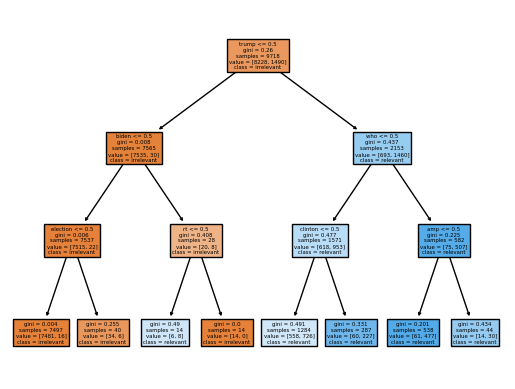

In [10]:
_ = tree.plot_tree(clf, feature_names=h, class_names=['irrelevant', 'relevant'], filled=True)

In [11]:
tree_text = tree.export_text(clf, feature_names=h.tolist())
print(tree_text)

|--- trump <= 0.50
|   |--- biden <= 0.50
|   |   |--- election <= 0.50
|   |   |   |--- class: 0
|   |   |--- election >  0.50
|   |   |   |--- class: 0
|   |--- biden >  0.50
|   |   |--- rt <= 0.50
|   |   |   |--- class: 1
|   |   |--- rt >  0.50
|   |   |   |--- class: 0
|--- trump >  0.50
|   |--- who <= 0.50
|   |   |--- clinton <= 0.50
|   |   |   |--- class: 1
|   |   |--- clinton >  0.50
|   |   |   |--- class: 1
|   |--- who >  0.50
|   |   |--- amp <= 0.50
|   |   |   |--- class: 1
|   |   |--- amp >  0.50
|   |   |   |--- class: 1



In [13]:
# print(f'Decision path: {clf.decision_path(X)}')